In [1]:
import sys
from pathlib import Path
APP_PATH = str((Path.cwd().parent / 'app').resolve())

if APP_PATH not in sys.path:
    sys.path.append(APP_PATH)
    
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from src.data import load_sessions, get_spikes, save_decoder_results
from src.decoding import cv_and_fit, decode
from src.plotting import plot_decision_metrics, plot_boxplot
from src.selectors import get_selectors
%matplotlib inline

In [3]:
DATA_DIR = Path.cwd().parent / 'data'

sessions = load_sessions(DATA_DIR, cleanup=False)
selectors = [get_selectors(session) for session in sessions]

Loading /home/jovyan/work/data/steinmetz_part0.npz...
Loading /home/jovyan/work/data/steinmetz_part1.npz...
Loading /home/jovyan/work/data/steinmetz_part2.npz...


In [4]:
for i in range(len(sessions)):
    session = sessions[i]
    sel = selectors[i]
    action_neurons = sum(sel["NEURON_ACTION"])
    vision_neurons = sum(sel["NEURON_VISUAL"])
    if action_neurons == 0 or vision_neurons == 0:
        continue
    print(" - ".join([
        f"Session {i:2d}",
        f"{len(session['response']):3d} trials",
        f"{action_neurons:3d} action neurons",
        f"{vision_neurons:3d} vision neurons",
        ",".join(sorted(set(session['brain_area'])))
    ]))

Session  0 - 214 trials - 113 action neurons - 178 vision neurons - ACA,CA3,DG,LS,MOs,SUB,VISp,root
Session  3 - 249 trials -  92 action neurons -  39 vision neurons - ACA,CA1,DG,LGd,LSr,MOs,SUB,TH,VISa,VISp,VPL
Session  6 - 252 trials -  39 action neurons - 101 vision neurons - CA3,CP,EPd,LD,PIR,SSp,VPL,root
Session  7 - 250 trials - 112 action neurons -  89 vision neurons - CA1,CA3,DG,ILA,LD,LP,LSr,MOs,PL,PO,SUB,TT,VISa,VISp,root
Session 10 - 342 trials - 447 action neurons - 275 vision neurons - CP,LSc,LSr,MOp,PT,root
Session 11 - 340 trials -   6 action neurons - 145 vision neurons - ACA,CA1,DG,LGd,LH,MD,MOs,PL,SUB,VISam,VISp,root
Session 12 - 300 trials -  61 action neurons -  66 vision neurons - ACA,CA1,DG,LGd,MB,MOs,MRN,MS,PL,RN,SCm,SCs,VISam,ZI,root
Session 13 - 268 trials - 200 action neurons -  79 vision neurons - CA1,MOs,MRN,ORB,PAG,RSP,SCm,SCs,VISp,root
Session 17 - 316 trials - 304 action neurons - 158 vision neurons - ACB,CA3,CP,LGd,OT,SI,SNr,TH,ZI,root
Session 18 - 247 t

In [5]:
DECODER_SESSION = 10
SESSION = sessions[DECODER_SESSION]
SELECTOR = selectors[DECODER_SESSION]

# Vision Decoder

In [6]:
VISION_NEURONS = SELECTOR["NEURON_VISUAL"]
VISION_TRIALS = ~SELECTOR["STIM_RIGHT_NONE"]
num_no_stim = VISION_TRIALS.sum() // 3
no_stim_trials = ~VISION_TRIALS
cutoff_index = np.where(no_stim_trials.cumsum() > num_no_stim)[0][0]
no_stim_trials[cutoff_index:] = False
VISION_TRIALS |= no_stim_trials
VISION_CLASS_NAMES = ["None", "Low", "Medium", "High"]

classes = SESSION['contrast_right']
label_encoder = LabelEncoder()
VISION_LABELS = label_encoder.fit_transform(classes)

[0.35044444444444445, 0.4464444444444444, 0.44377777777777777, 0.4697777777777778, 0.43222222222222223]
0.4285333333333333


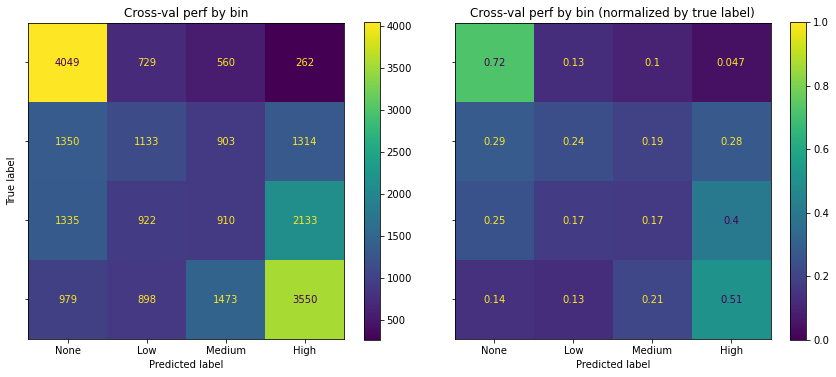

In [7]:
vision_clf = LogisticRegression(penalty='l2', multi_class='ovr', solver='saga', max_iter=5000)
_ = cv_and_fit(
    vision_clf,
    SESSION,
    SELECTOR,
    VISION_NEURONS,
    VISION_TRIALS,
    (0, 100),
    VISION_LABELS,
    VISION_CLASS_NAMES,
    align=50,
    baseline_bins=None,
    smoothing=(17, 2.5),
)

In [8]:
vision_decisions, vision_posteriors = decode(
    vision_clf,
    get_spikes(
        SESSION,
        VISION_NEURONS,
        VISION_TRIALS,
        (0, 100),
        align=50,
        baseline_bins=None,
        smoothing=(17, 2.5),
    ),
    np.array([
        SELECTOR['CHOICE_CORRECT'][SELECTOR["STIM_RIGHT_LOW"]].mean(),
        SELECTOR['CHOICE_CORRECT'][SELECTOR["STIM_RIGHT_MEDIUM"]].mean(),
        SELECTOR['CHOICE_CORRECT'][SELECTOR["STIM_RIGHT_HIGH"]].mean(),
    ])
)

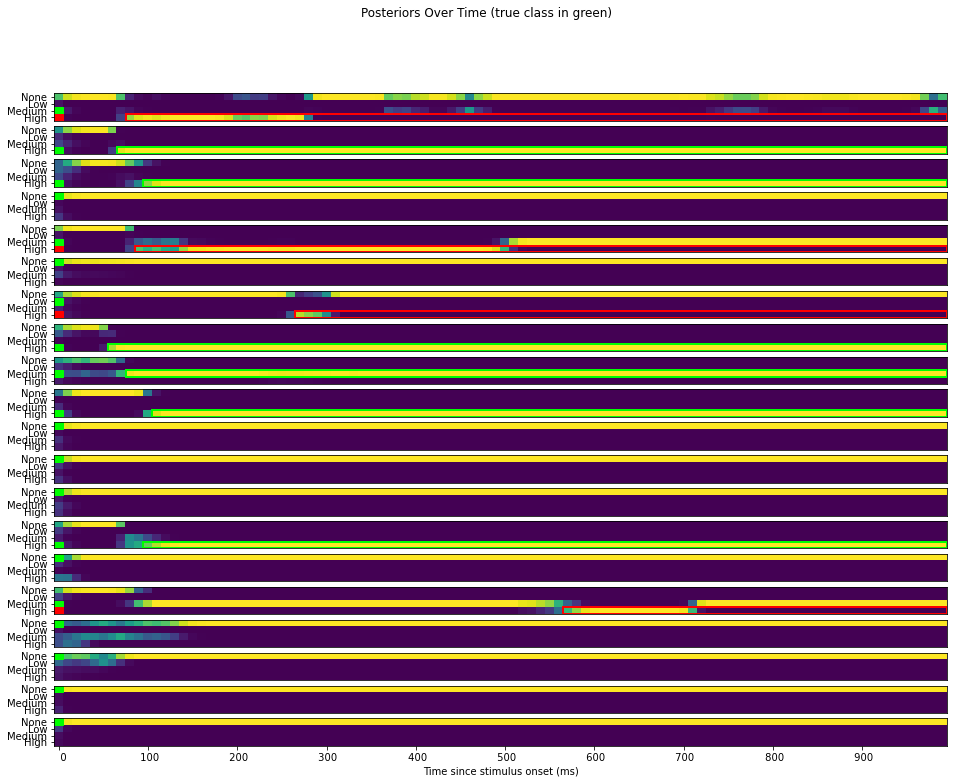

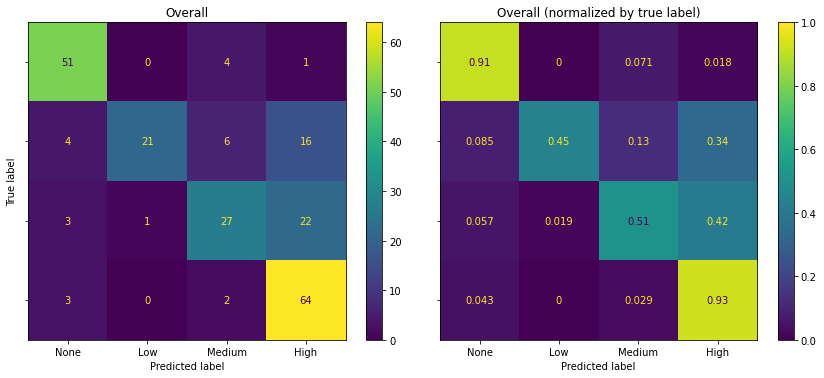

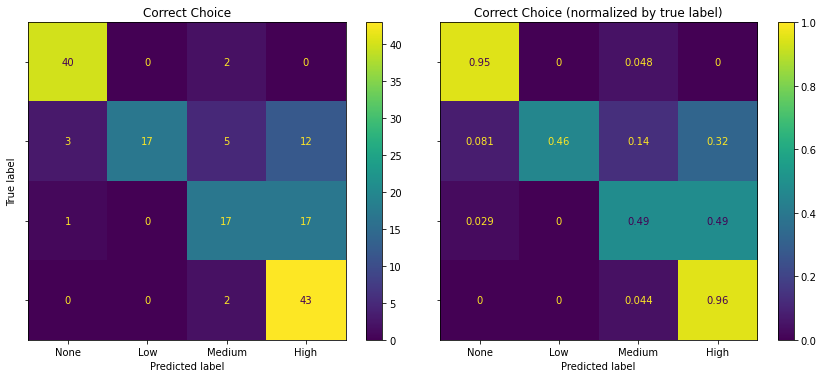

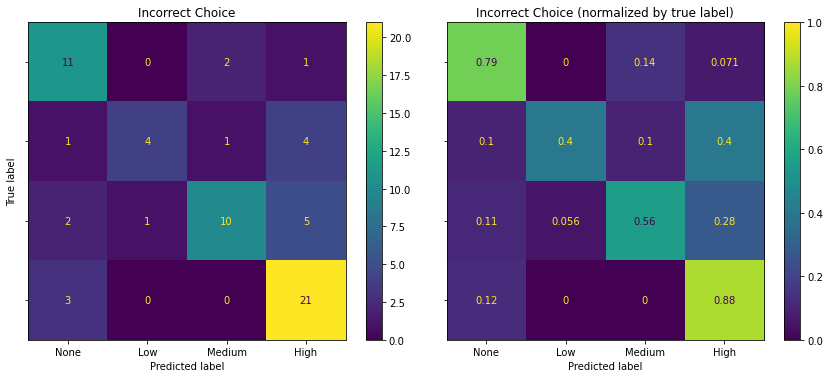

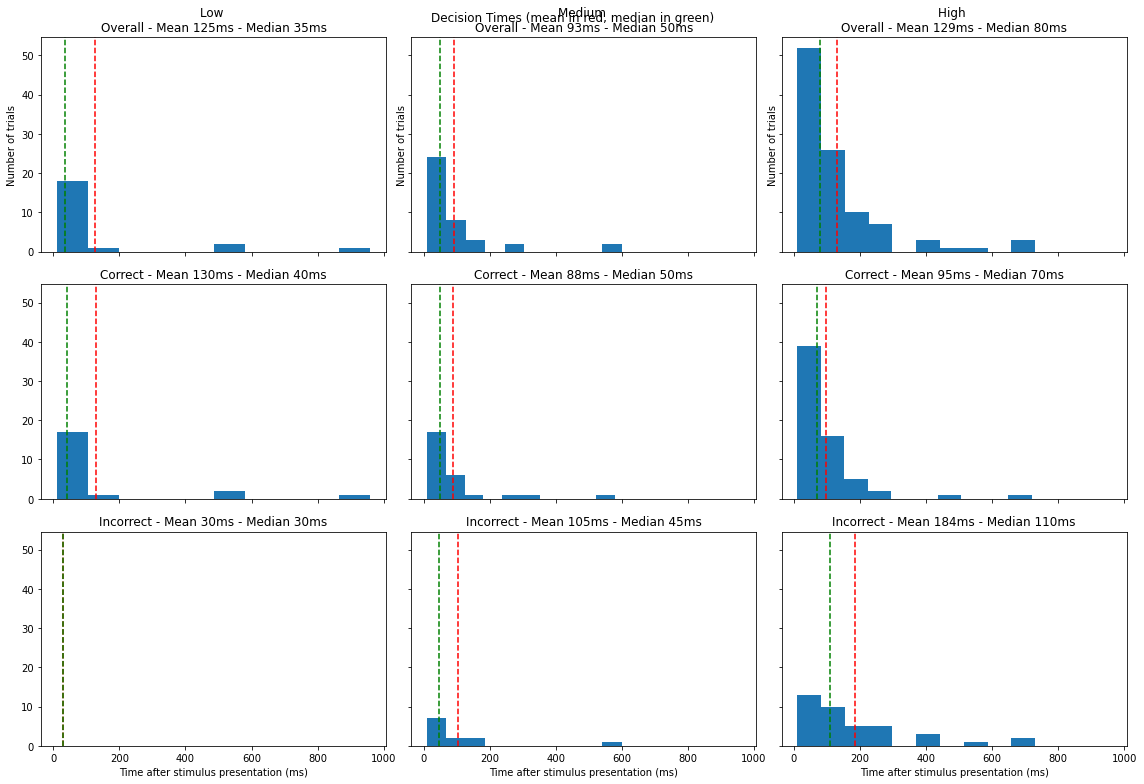

In [9]:
plot_decision_metrics(
    vision_decisions,
    vision_posteriors,
    SELECTOR,
    VISION_TRIALS,
    VISION_LABELS,
    VISION_CLASS_NAMES
)

In [10]:
save_decoder_results(DATA_DIR, DECODER_SESSION, VISION_TRIALS, 'vision', vision_decisions, vision_clf)

# Action Decoder

[0.7692307692307693, 0.717948717948718, 0.8685897435897436, 0.9237179487179488, 0.8618421052631579]
0.8282658569500674


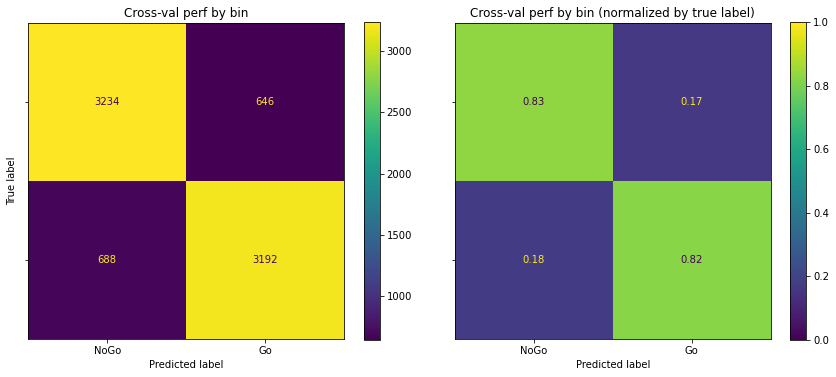

In [11]:
ACTION_NEURONS = SELECTOR["NEURON_ACTION"]
ACTION_TRIALS = np.copy(SELECTOR["CHOICE_NONE"])
ACTION_TRIALS[np.where(~ACTION_TRIALS)[0][:ACTION_TRIALS.sum()]] = True
ACTION_LABELS = 1 - SELECTOR["CHOICE_NONE"]
ACTION_CLASS_NAMES = ["NoGo", "Go"]

reaction_times = SESSION['reaction_time'][ACTION_TRIALS, 0] / 10
no_response = np.isinf(reaction_times)
reaction_times[no_response] = reaction_times[~no_response].mean()
reaction_times = reaction_times.astype(int)

action_clf = LogisticRegression(penalty='l2', solver='saga', max_iter=5000)
action_threshold = cv_and_fit(
    action_clf,
    SESSION,
    SELECTOR,
    ACTION_NEURONS,
    ACTION_TRIALS,
    (-20, 20),
    ACTION_LABELS,
    ACTION_CLASS_NAMES,
    align=reaction_times + 50,
    baseline_bins=None,
    smoothing=(17, 2.5),
)

In [12]:
action_decisions, action_posteriors = decode(
    action_clf,
    get_spikes(
        SESSION,
        ACTION_NEURONS,
        ACTION_TRIALS,
        (0, 200),
        align=50,
        baseline_bins=None,
        smoothing=(17, 2.5),
    ),
    action_threshold
)

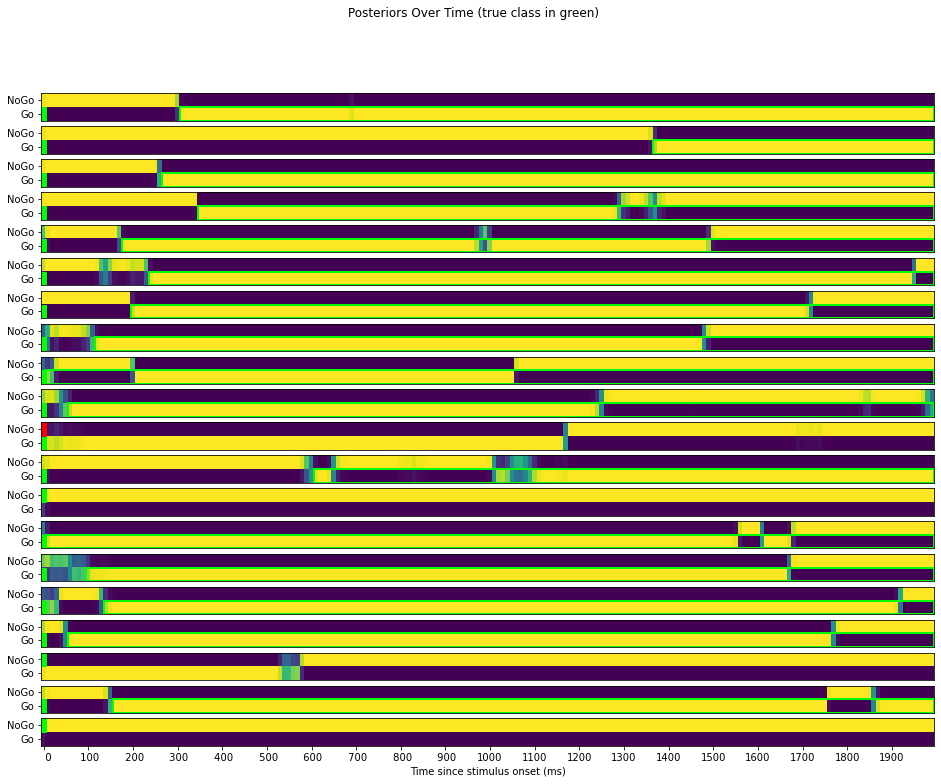

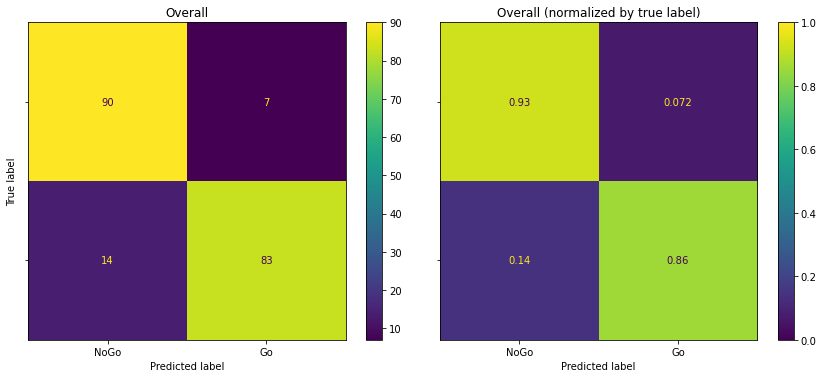

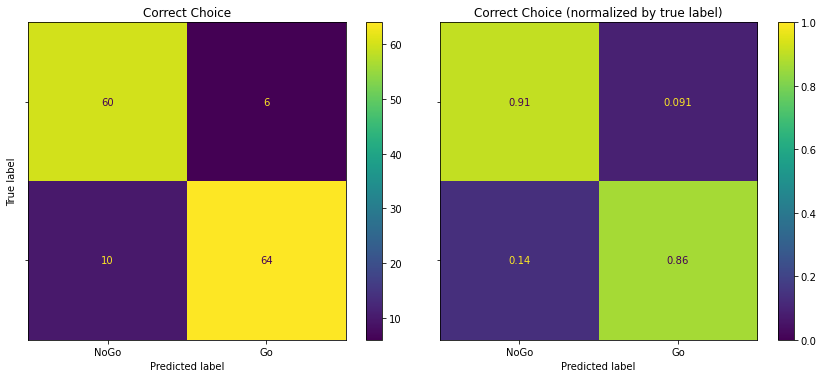

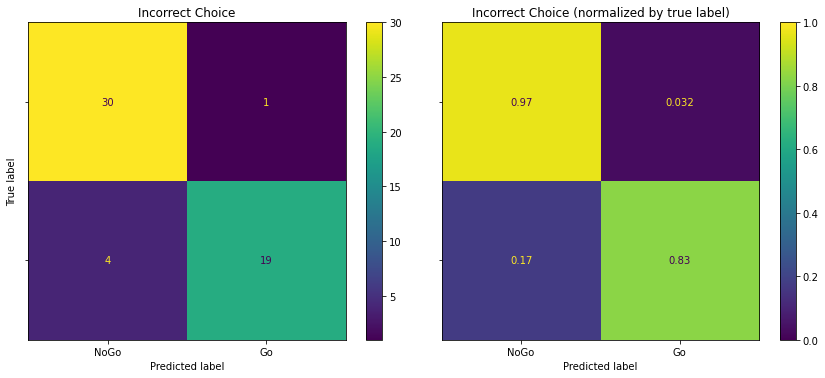

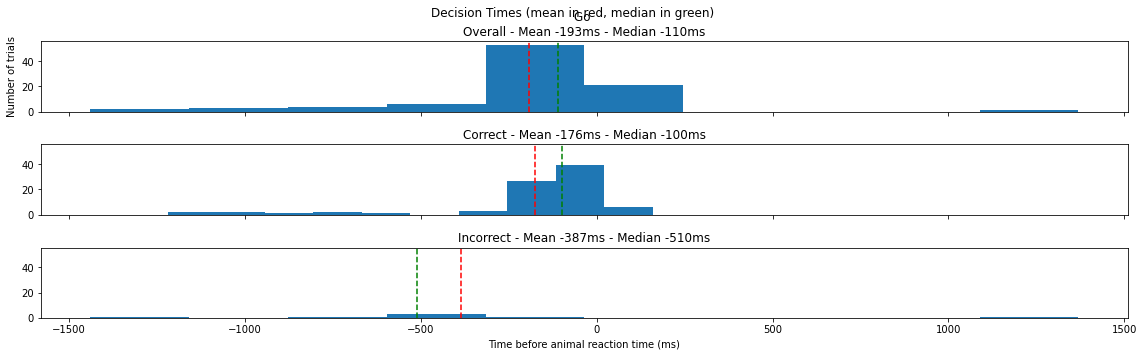

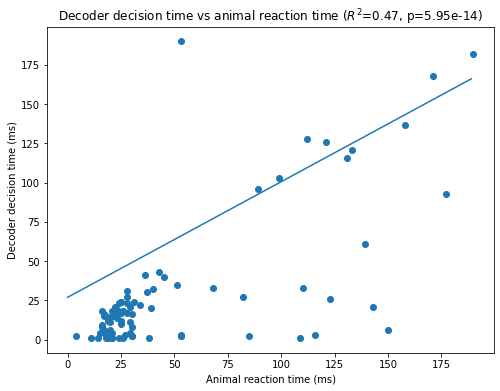

In [13]:
plot_decision_metrics(
    action_decisions,
    action_posteriors,
    SELECTOR,
    ACTION_TRIALS,
    ACTION_LABELS,
    ACTION_CLASS_NAMES,
    hist_xlabel='before animal reaction time',
    regress=reaction_times
)

In [14]:
save_decoder_results(DATA_DIR, DECODER_SESSION, ACTION_TRIALS, 'action', action_decisions, action_clf)

# Deliberation Time

In [15]:
TIME_TRIALS = VISION_TRIALS & ACTION_TRIALS

deliberation_times = action_decisions[VISION_TRIALS[ACTION_TRIALS], 1] - vision_decisions[ACTION_TRIALS[VISION_TRIALS], 1]
contrasts = SESSION['contrast_right'][TIME_TRIALS]
is_choice_correct = SELECTOR['CHOICE_CORRECT'][TIME_TRIALS]
is_go = ~SELECTOR['CHOICE_NONE'][TIME_TRIALS]

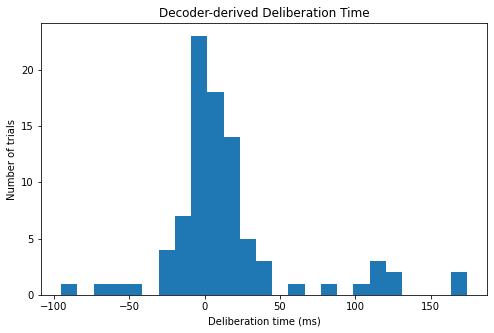

In [16]:
plt.figure(figsize=(8, 5))
plt.hist(deliberation_times[is_go], bins=25)
plt.title("Decoder-derived Deliberation Time")
plt.xlabel("Deliberation time (ms)")
plt.ylabel("Number of trials")
plt.show()

Ttest_indResult(statistic=-2.0069839599158823, pvalue=0.055902415120864316)


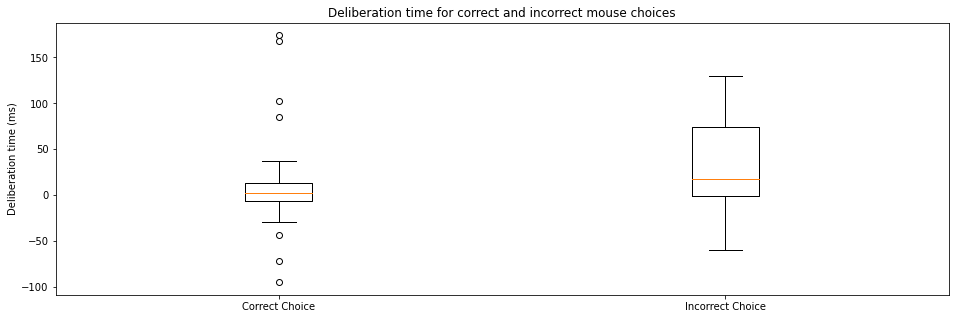

In [17]:
plot_boxplot(
    [
        deliberation_times[is_go & is_choice_correct],
        deliberation_times[is_go & ~is_choice_correct]
    ],
    ["Correct Choice", "Incorrect Choice"],
    "for correct and incorrect mouse choices"
)

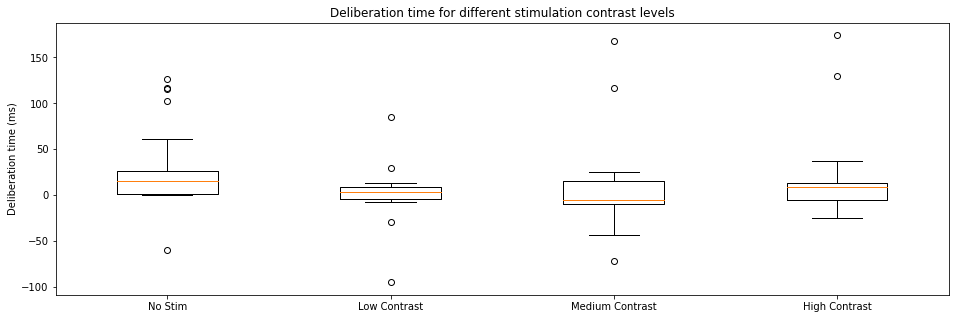

In [18]:
plot_boxplot(
    [
        deliberation_times[is_go & (contrasts == 0)],
        deliberation_times[is_go & (contrasts == 0.25)],
        deliberation_times[is_go & (contrasts == 0.5)],
        deliberation_times[is_go & (contrasts == 1)],
    ],
    ["No Stim", "Low Contrast", "Medium Contrast", "High Contrast"],
    "for different stimulation contrast levels"
)

Ttest_indResult(statistic=-1.8835128772305274, pvalue=0.0833809576930455)


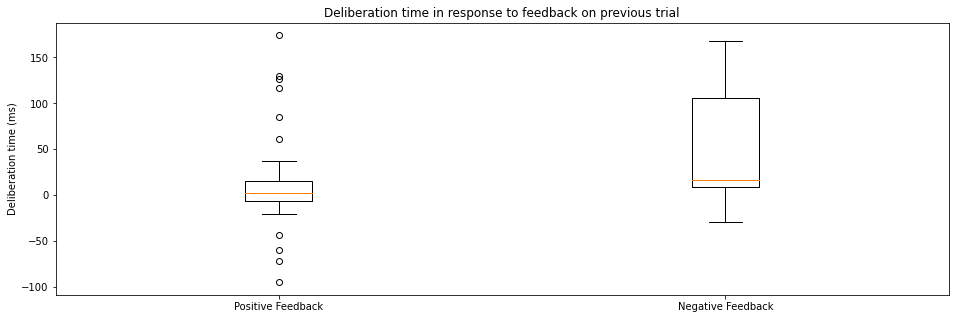

In [19]:
feedback = SESSION['feedback_type'][:-1][TIME_TRIALS[1:]]
plot_boxplot(
    [
        deliberation_times[1:][is_go[1:] & (feedback == 1)],
        deliberation_times[1:][is_go[1:] & (feedback == -1)],
    ],
    ["Positive Feedback", "Negative Feedback"],
    "in response to feedback on previous trial"
)

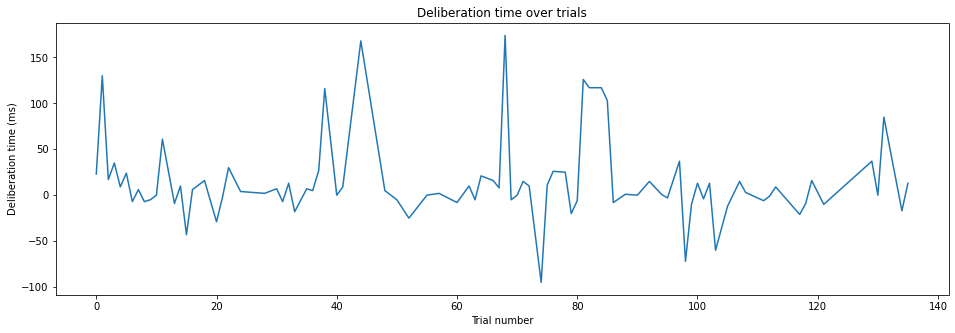

In [20]:
plt.figure(figsize=(16, 5))
plt.plot(np.where(TIME_TRIALS)[0][is_go], deliberation_times[is_go])
plt.title("Deliberation time over trials")
plt.xlabel("Trial number")
plt.ylabel("Deliberation time (ms)")
plt.show()